In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer



In [3]:
data = pd.read_csv('beer-servings.csv')
data = data.iloc[:,1:]
data.head()


,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,continent
0,Afghanistan,0.0,0.0,0.0,0.0,Asia
1,Albania,89.0,132.0,54.0,4.9,Europe
2,Algeria,25.0,0.0,14.0,0.7,Africa
3,Andorra,245.0,138.0,312.0,12.4,Europe
4,Angola,217.0,57.0,45.0,5.9,Africa


In [ ]:
def replace_outliers(df,column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3-q1
    lower_bond = q1 - 1.5*iqr
    upper_bond = q3 + 1.5*iqr
    df[column_name] = df[column_name].clip(lower = lower_bond,upper = upper_bond)
    return df[column_name]



numeric_columns = data.select_dtypes(include='number').columns.to_list()
numeric_columns.remove('total_litres_of_pure_alcohol')
for col in numeric_columns:
    data[col] = replace_outliers(data,col)



<Axes: >

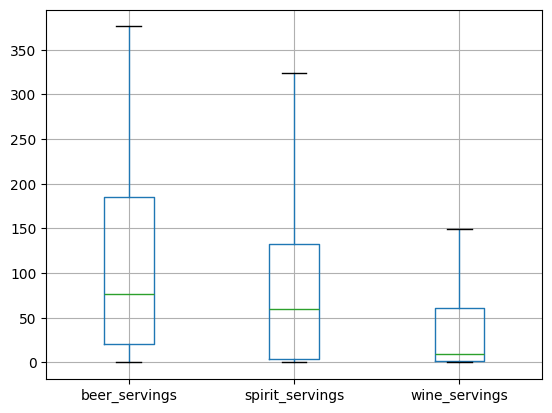

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

data[numeric_columns].boxplot()

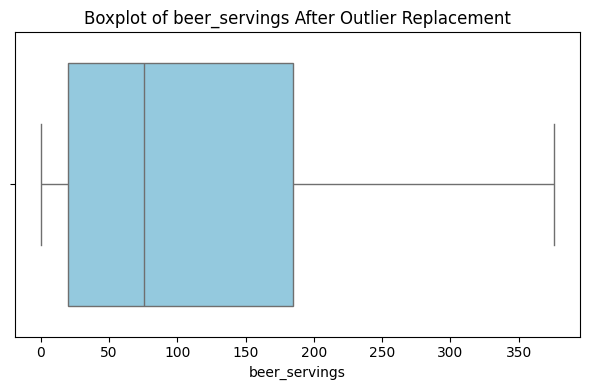

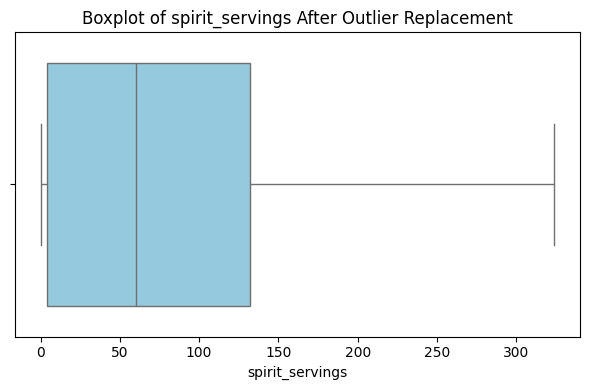

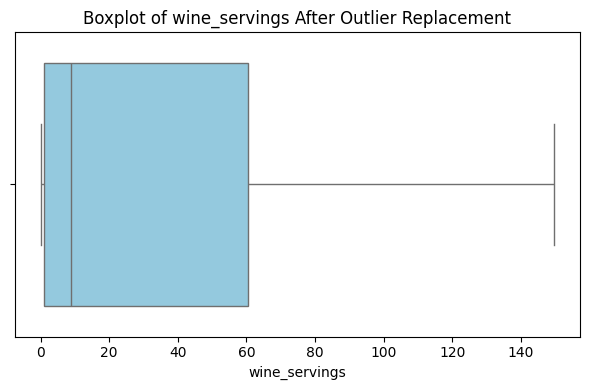

In [14]:
import seaborn as sns

for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x=col, color='skyblue')
    plt.title(f'Boxplot of {col} After Outlier Replacement')
    plt.tight_layout()
    plt.show()


In [26]:
data = data.dropna(subset = ['total_litres_of_pure_alcohol'])

#split features and target
y = data['total_litres_of_pure_alcohol']
X = data.drop('total_litres_of_pure_alcohol',axis = 1)

X.head()
y.head()

0     0.0
1     4.9
2     0.7
3    12.4
4     5.9
Name: total_litres_of_pure_alcohol, dtype: float64

In [27]:
numeric_features = X.select_dtypes(include = 'number').columns.to_list()
categorical_features = X.select_dtypes(include = 'object').columns.to_list()

In [40]:
from sklearn.preprocessing import PolynomialFeatures
# pipelines

numeric_transormer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('poly',PolynomialFeatures(degree=2,include_bias=False)),   #to make this to polymomial regression
    ('scaler',StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy="most_frequent")),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])
# columns transformer

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transormer,numeric_features),
    ('cat',categorical_transformer,categorical_features)
])



In [41]:
# full pipeline with model
model_pipeline = Pipeline(steps = [
    ('preprocessor',preprocessor),
    ('regressor',LinearRegression())
])


In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
model_pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
y_pred = model_pipeline.predict(X_test)
mse = mean_squared_error(y_pred,y_test)
r2 = r2_score(y_pred,y_test)
mse
r2
mse

1.1219645543344645